# Analiza kretanja masine

- cilj je na osnovu skupa anotiranih tacaka nauciti algoritam da generise mapu poslova
- 1: obuciti NN tako da ume da prepoznake tacke koje pripadaju liniji i krivoj (RAD SINTEZA)
- 2: grupisati tacke u fazi linije (fazi linija je odredjena pocetnom i krajnom tackom te koeficientom pravca)
- 3: iskoristi SOM da bi se grupisali svi koeficienti pravca
- 4: na osnovu dobijenih rezultata izvrsiti korekciju fazi linija
- 5: prepoznavanje tacaka koje pripadaju servisnim putevima linearna regresija

## 1. Format ulaznih podataka

```
0 Date	
1 Time	
2 AbC	
3 AC	
4 CdE	
5 CE	
6 AbcdE	
7 AE	
8 speed	
9 cog	
10 lon	   - koordinate tacke C
11 lat	
12 segment - redni broj segmenta	
13 class - [line, curve]
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
%matplotlib inline

def load_data(file_name):
    with open(file_name, 'r') as f:
        data = f.read()
    data_set = []    
    lines = data.split('\n')
    p = 0
    n = 0
    for line in lines[1:]:
        parts = line.split('\t')
        if len(parts)>1:
            item = []
            for i in range(1, 13):
                item.append(float(parts[i]))
            if(parts[13] == 'line'):
                item.append(float(-1))
            else:
                item.append(float(1))            
            
            data_set.append(np.array(item))            
            if(parts[13] == 'line'):
                p += 1
            else:
                n += 1
    print p, n
    data_set = np.array(data_set)
    return data_set


In [2]:
data = load_data('data/rad_podaci_etran.csv')

16541 1739


## Data

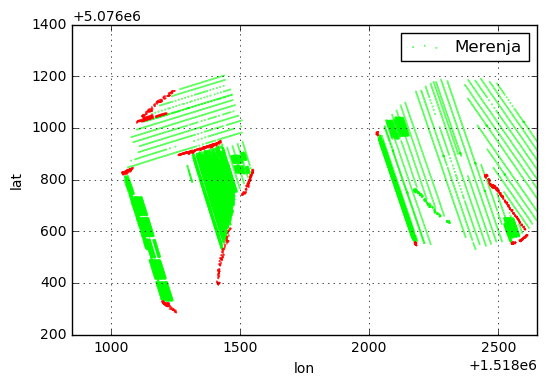

In [3]:
klon = 78847
klat = 111132

color = [(1*item==1, 1*item==-1, 0) for item in data[1:,12]]

plt.scatter(klon*data[1:,9], klat*data[1:,10], color=color, s=0.1, label='Merenja');
plt.legend()
plt.xlabel('lon')
plt.ylabel('lat')
plt.axis('equal')
plt.grid(True)

## Neuronska mreza za SINTEZA rad

In [5]:
from keras.models import Sequential
from keras.layers.core import Activation, Dense
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(3, input_dim=6))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('tanh'))

Using Theano backend.


## Algoritam za obucavanje

In [6]:
sgd = SGD(lr=0.01, decay=0.00001, momentum=0.7)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])


### Obucavajuci skup

In [7]:
train_rank = 1000
test_rank = 500

train_subset = np.random.choice(data[1:, :].shape[0], train_rank)
test_subset = np.random.choice(data[1:, :].shape[0], test_rank)

### Trening

In [8]:
training = model.fit(data[train_subset,1:7], data[train_subset,12], nb_epoch=1000, batch_size=50, verbose=0, validation_data=(data[test_subset,1:7], data[test_subset,12]))
print training.history['loss'][-1]

0.171640241519


0.171640241519


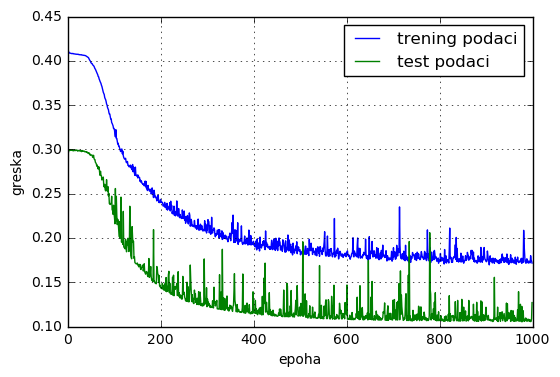

In [9]:
#['acc', 'loss', 'val_acc', 'val_loss']
print training.history['loss'][-1]

x = np.arange(0, len(training.history['loss']))

plt.plot(x, training.history['loss'], c='b', label='trening podaci')
plt.plot(x, training.history['val_loss'], c='g', label='test podaci')
plt.xlabel('epoha')
plt.legend()
plt.ylabel('greska')
plt.grid(True)


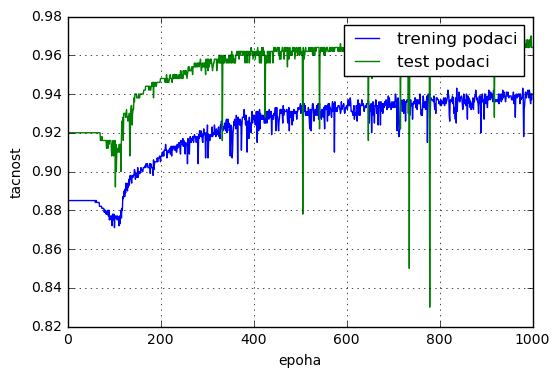

In [10]:
x = np.arange(0, len(training.history['loss']))

plt.plot(x, training.history['acc'], c='b', label='trening podaci')
plt.plot(x, training.history['val_acc'], c='g', label='test podaci')
plt.xlabel('epoha')
plt.legend()
plt.ylabel('tacnost')
plt.grid(True)


## Grupisanje tačaka u linije

Linearni model po parametrima W i b


### Pristupi:

- 1) Tensorflow sa Adam optimizatorom
- 2) Klasicni polyfit
- 3) Avg izmisljen


### 1) Tensorflow

In [47]:
import numpy.linalg as linalg
import tensorflow as tf
rng = np.random
import random

# Parameters
learning_rate = 0.1
training_epochs = 100
batch = 50
display_step = 50


In [48]:
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights
W = tf.Variable(rng.randn(), name="weight")
b = tf.Variable(rng.randn(), name="bias")

# Linear model
pred = tf.add(tf.multiply(X, W), b)

# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/50 #/(2*n_samples)

# Gradient descent
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

def process_line_tf(rb, points):
    points = np.array(points)
    lon, lat = klon*points[:,9], klat*points[:,10]
    train_X = lon - lon.mean(axis=0)
    train_Y = lat - lat.mean(axis=0)
    n_samples = train_X.shape[0]

    train_subset = np.random.choice(train_X.shape[0], 10)    
    
    # Fit all training data
    for epoch in range(training_epochs):
        for (x, y) in zip(train_X[train_subset], train_Y[train_subset]):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        c = sess.run(cost, feed_dict={X: train_X, Y:train_Y})                
        if(c<0.5):
            break          
            
    if(debug):
        training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
        print(n_samples, "Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b), '\n')
        # Graphic display
        plt.plot(train_X, train_Y, 'ro', label='Original data')
        plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')
        plt.legend()
        plt.show()    
    
    #training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
    #print(rb, n_samples, training_cost, sess.run(W), sess.run(b))
    print(rb, n_samples, sess.run(W), sess.run(b))

In [49]:
debug = False

# Launch the graph
sess = tf.Session()
sess.run(init)

In [50]:
%%time
line = []
rb = -1
for el in data:
    if(rb>10):
        break
    if el[12]==1: # preskociti tacke koje ne pripadaju linijama
        continue
    else:
        if el[11] == rb:
            line.append(el)
        else:
            if(len(line)>10):
                process_line_tf(rb, line)
            rb = el[11]
            line = []


(1.0, 16, -3.2521267, 0.73248154)
(3.0, 192, -2.9423251, 0.15497413)
(4.0, 198, -2.956903, -1.0282688)
(5.0, 61, -2.9542372, -0.41456795)
(6.0, 66, -2.9469688, -0.19251432)
(7.0, 72, -2.9488714, -0.014289301)
(8.0, 54, -2.9192708, 0.013967694)
(9.0, 71, -2.8962548, -0.054793909)
(10.0, 109, -2.9235489, 0.0081029786)
CPU times: user 1.09 s, sys: 112 ms, total: 1.2 s
Wall time: 680 ms


In [51]:
sess.close() 

### 2) Polyfit

In [66]:
def process_line(rb, points):
    points = np.array(points)
    lon, lat = klon*points[:,9], klat*points[:,10]
    train_X = lon
    train_Y = lat
    train_X = lon - lon.mean(axis=0)
    train_Y = lat - lat.mean(axis=0)
    n_samples = train_X.shape[0]

    w, b = np.polyfit(train_X, train_Y, 1)
    #print(rb, n_samples, w, b)
    
    # Graphic display
    #plt.plot(train_X, train_Y, 'ro', label='Original data')
    #plt.plot(train_X, w * train_X + b, label='Fitted line')
    #plt.legend()
    #plt.show()    



In [67]:
%%time

line = []
rb = -1
for el in data:
    if(rb>200):
        break
    if el[12]==1: # preskociti tacke koje ne pripadaju linijama
        continue
    else:
        if el[11] == rb:
            line.append(el)
        else:
            if(len(line)>10):
                process_line(rb, line)
            rb = el[11]
            line = []

CPU times: user 60 ms, sys: 4 ms, total: 64 ms
Wall time: 68.5 ms


## 3) Avg - izmisljen

In [72]:
def process_line_i(rb, points):
    points = np.array(points)
    lon, lat = klon*points[:,9], klat*points[:,10]
    train_X = lon
    train_Y = lat
    train_X = lon - lon.mean(axis=0)
    train_Y = lat - lat.mean(axis=0)
    n_samples = train_X.shape[0]

    train_subsetA = np.random.choice(train_X.shape[0], 10)    
    train_subsetB = np.random.choice(train_X.shape[0], 10)    
    
    # Fit all training data
    w = 0
    b = 0
    n = 0
    for (xa, ya) in zip(train_X[train_subsetA], train_Y[train_subsetA]):
        for (xb, yb) in zip(train_X[train_subsetB], train_Y[train_subsetB]):
            if(xa-xb!=0):
                n += 1
                ww = (ya-yb)/(xa-xb)
                bb = ya-ww*xa
                w += ww
                b += bb
    
    w = w/n
    b = b/n
    #print(rb, n_samples, w, b)
    
    # Graphic display
    #plt.plot(train_X, train_Y, 'ro', label='Original data')
    #plt.plot(train_X, w * train_X + b, label='Fitted line')
    #plt.legend()
    #plt.show()   

In [73]:
%%time

line = []
rb = -1
for el in data:
    if(rb>200):
        break
    if el[12]==1: # preskociti tacke koje ne pripadaju linijama
        continue
    else:
        if el[11] == rb:
            line.append(el)
        else:
            if(len(line)>10):
                process_line_i(rb, line)
            rb = el[11]
            line = []

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 73.6 ms
